<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span></li><li><span><a href="#Adjust-Input-Shape" data-toc-modified-id="Adjust-Input-Shape-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><code>Adjust</code> Input Shape</a></span></li><li><span><a href="#func" data-toc-modified-id="func-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>func</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Leave-1-channel" data-toc-modified-id="Leave-1-channel-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Leave 1 channel</a></span></li><li><span><a href="#Remove-1-channel" data-toc-modified-id="Remove-1-channel-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Remove 1 channel</a></span></li><li><span><a href="#Remove-2-channel" data-toc-modified-id="Remove-2-channel-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Remove 2 channel</a></span></li></ul></li><li><span><a href="#End" data-toc-modified-id="End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>End</a></span></li></ul></div>

In [1]:
ipynb_title = "class__getLastOutputByChangingHiddenOutput__Conv1d_model__SimpleSinFuncWithNoNoise"
model_filename = "model__create_Conv1d_model__SimpleSinFuncWithNoNoise.h5"

__{{ipynb_title}}.ipynb__

1. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
1. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成

In [51]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import math

import keras
print("Keras version : ", keras.__version__)

Keras version :  2.1.6


## Setting

### Path

In [13]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [14]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)

for _Path in path_list:
    _path = str(_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5
True :  /home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data
True :  /home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data/plot_images


## 時系列データ作成

$$
\textbf{toyfunc(t)} = \sin\left( \frac{2 \pi}{T} t \right)
$$

In [15]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

In [16]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, noiseAmpl=0.05):
    """
    T : 
      sin波の周期
    ampl : 
      ノイズ振幅調整
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            + mySin(t=t, period=100)
            + noiseAmpl * noise )

## `Adjust` Input Shape

In [17]:
tStart = 10000
windowsize = 100
predictsize = 1
wave_size = 300
assert wave_size - windowsize > windowsize  # 後に畳み込むにはこの条件が必要

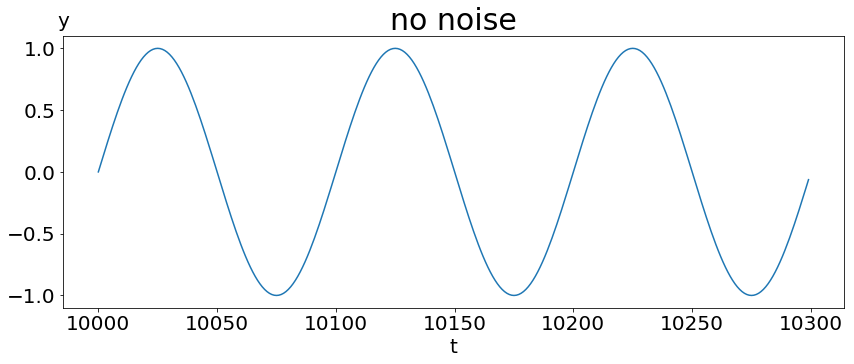

In [18]:
filename = "{}__wave_with_noise.png".format(ipynb_title)

#----------------------------------------
# create a wave
#----------------------------------------
t, wave = toy_func(tStart=tStart, tStop=tStart+wave_size, noiseAmpl=0)

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t, wave)

title = "no noise"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

In [19]:
#----------------------------------------
# create input data
#----------------------------------------
input_arr = np.empty(shape=(0, windowsize))
print(input_arr.shape)
for i in range( wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_arr = np.append(arr=input_arr,
                           values=wave[i:(i+windowsize)].reshape(1, -1),
                           axis=0)
print("input_arr.shape  : ", input_arr.shape)
input_arr = input_arr.reshape((-1, windowsize, 1))
print("input_arr.shape  : ", input_arr.shape)

(0, 100)
input_arr.shape  :  (200, 100)
input_arr.shape  :  (200, 100, 1)


## func

- 入力波形 : メソッド
- 削除したいチャネルがある層

In [31]:
type(model)

keras.models.Sequential

In [35]:
def removeIntermidiateChannels(input_array, model, layer_index=0, channel_index=[0]):
    """
    model : keras model
    layer_index : int
    channel_index=[]
    reference:
      - https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    """
    from keras import backend as K

    # check input
    assert type(model) == keras.models.Sequential
    assert type(layer_index) == int
    assert type(channel_index) == list 

    # get first half layers output
    get_first_half = K.function(inputs=[model.input],
                                outputs=[model.layers[layer_index].output])
    first_half_output = get_first_half(inputs=[input_array])[0]

    # remove channels
    shape = first_half_output.shape[:2]
    for idx in channel_index:
        first_half_output[:,:,idx] = np.zeros(shape)

    # get second half layers output
    get_second_half = K.function(inputs=[model.layers[layer_index+1].input],
                                 outputs=[model.output])
    second_half_output = get_second_half(inputs=[first_half_output])[0]
    return second_half_output

In [36]:
removeIntermidiateChannels(model=model, layer_index=0, channel_index=[1], input_array=input_arr).shape

(200, 1, 1)

In [63]:
removeIntermidiateChannels(model=model, layer_index=0, channel_index=[0, 1, 2, 3], input_array=input_arr).shape

(200, 1, 1)

## Plot

In [43]:
channels_num = int(model.layers[0].output.shape[2])

### Leave 1 channel

In [65]:
ch_list = [ ch for ch in range(channels_num) ]
ch_list.remove(0)
ch_list

[1, 2, 3, 4, 5, 6, 7]

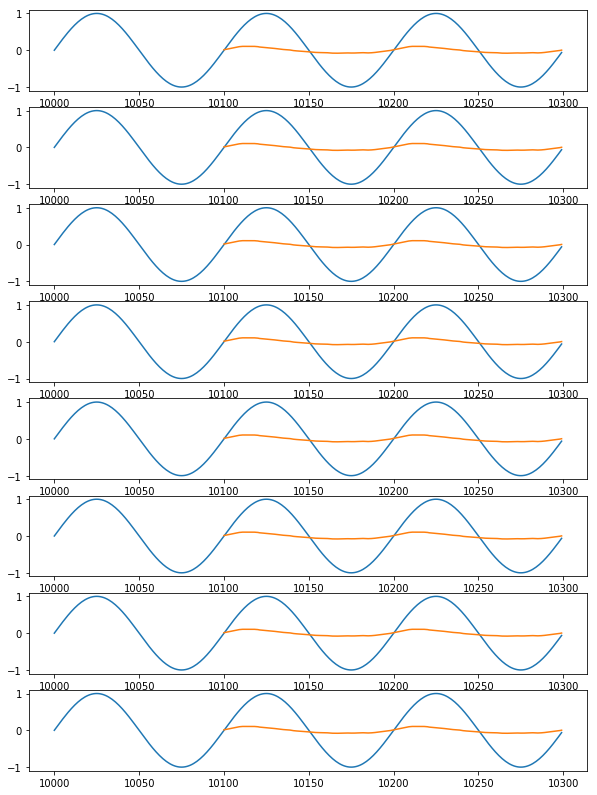

In [69]:
fig = plt.figure(figsize=(10, 14))
for ch in range(channels_num):
    ax = fig.add_subplot(channels_num,1,ch+1)
    ax.plot(t, wave)
    ch_list = [ ch for ch in range(channels_num) ]
    ch_list.remove(0)
    last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                   model=model,
                                                   layer_index=0,
                                                   channel_index=ch_list)
    ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

### Remove 1 channel

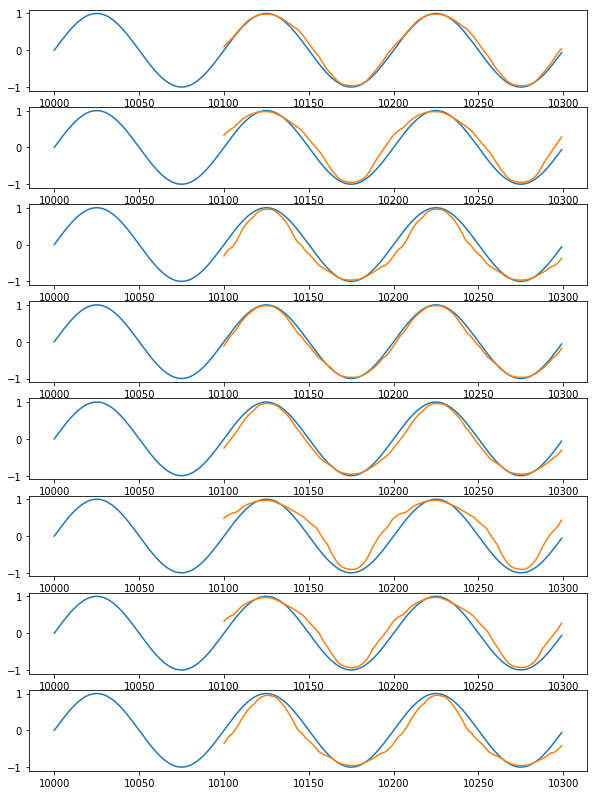

In [49]:
fig = plt.figure(figsize=(10, 14))
for ch in range(channels_num):
    ax = fig.add_subplot(channels_num,1,ch+1)
    ax.plot(t, wave)
    last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                   model=model,
                                                   layer_index=0,
                                                   channel_index=[ch])
    ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

### Remove 2 channel

In [53]:
plot_size = math.factorial(channels_num)
plot_size

40320

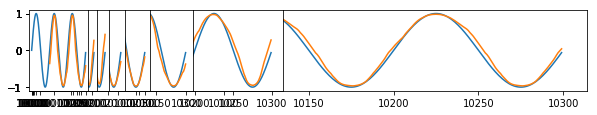

In [80]:
fig = plt.figure(figsize=(10, 14))
for ch in range(channels_num):
    ax = fig.add_subplot(channels_num,ch+1,1)
    #ax = fig.add_subplot(channels_num,1,ch+1)
    ax.plot(t, wave)
    last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                   model=model,
                                                   layer_index=0,
                                                   channel_index=[ch])
    ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


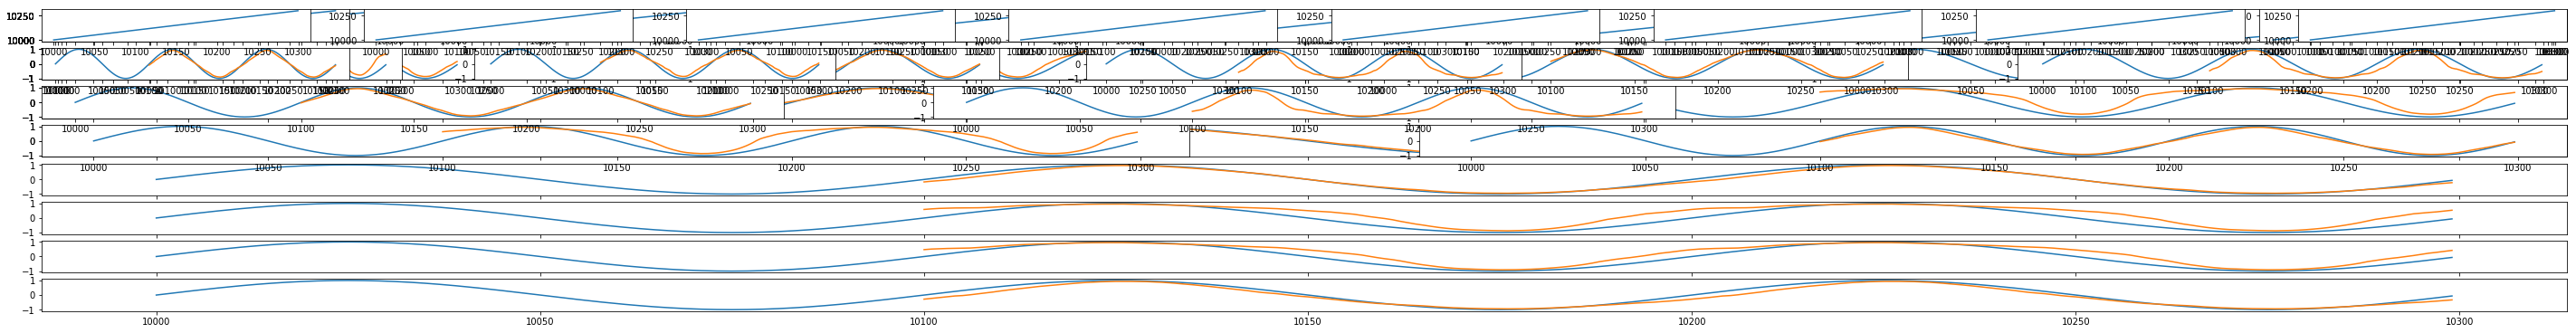

In [75]:
fig = plt.figure(figsize=(50, 50))
plot_size = channels_num * channels_num
for ch1 in range(channels_num):
    for ch2 in range(channels_num):
        if ch1 >= ch2:
            ax = fig.add_subplot(plot_size,ch1+1,ch2+1)
            ax.plot(t, t)
        else:
            ax = fig.add_subplot(plot_size,ch1+1,ch2+1)
            ax.plot(t, wave)
            last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                           model=model,
                                                           layer_index=0,
                                                           channel_index=[ch1, ch2])
            ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

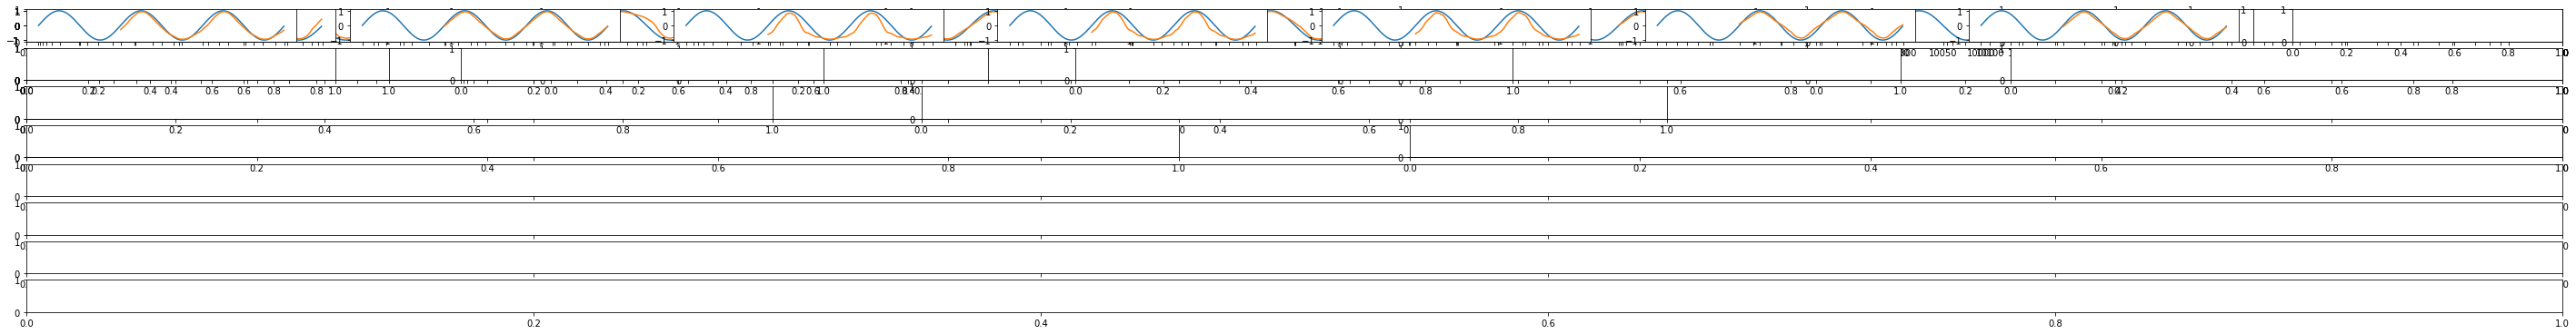

In [60]:
fig = plt.figure(figsize=(50, 50))
plot_size = channels_num * channels_num
for ch1 in range(channels_num):
    for ch2 in range(channels_num):
        if ch1 >= ch2:
            ax = fig.add_subplot(plot_size,ch2+1,ch1+1)
        else:
            ax = fig.add_subplot(plot_size,ch2+1,ch1+1)
            ax.plot(t, wave)
            last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                           model=model,
                                                           layer_index=0,
                                                           channel_index=[ch1, ch2])
            ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

## End